# Joint Hands-On Session Qiskit & Tket

### Sept. 6, 2022, Dr. Elisa Bäumer

## Noisy backends and measurement error mitigation

Present day quantum computers are subject to noise of various kinds. The principle behind error mitigation is to reduce the effects from a specific source of error by classically post-processing the counts. Here we will look at mitigating measurement errors.

### Measurement error mitigation
We start by creating a set of circuits that prepare and measure each of the $2^n$ basis states, where $n$ is the number of qubits. The outcome statistics are then captured by a calibration matrix $M$, where the element $M_{ij}$ gives the probability to get output state $|i\rangle$ when state $|j\rangle$ was prepared. 

In [1]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter

n=3
meas_calibs, state_labels = complete_meas_cal(range(n), circlabel='mcal')

Next, we need to choose our device:

In [2]:
from qiskit import IBMQ, execute

# IBMQ.save_account(TOKEN) # needed only for the first time
provider = IBMQ.load_account() # load your IBM Quantum Experience account
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='summer-school-qi')

In [3]:
[(b.name(), b.configuration().n_qubits) for b in provider.backends()]

[('ibmq_qasm_simulator', 32),
 ('ibmq_lima', 5),
 ('ibmq_belem', 5),
 ('ibmq_quito', 5),
 ('simulator_statevector', 32),
 ('simulator_mps', 100),
 ('simulator_extended_stabilizer', 63),
 ('simulator_stabilizer', 5000),
 ('ibmq_jakarta', 7),
 ('ibmq_manila', 5),
 ('ibm_lagos', 7),
 ('ibm_nairobi', 7),
 ('ibm_perth', 7),
 ('ibm_oslo', 7)]

Since I have reserved ``ibm_nairobi``, ``ibm_perth`` and ``ibmq_jakarta`` for the next two hours, I'd recommend choosing one of those for now.

In [4]:
backend = provider.get_backend('ibm_nairobi')

Now we run these calibration circuits on our real device! 

In [7]:
import qiskit.tools.jupyter
%qiskit_job_watcher

shots = 10000
layout = [4,5,6]
cal_job = execute(meas_calibs, backend=backend, initial_layout=layout, shots=shots)
print(cal_job.job_id())

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [6]:
from qiskit.visualization import array_to_latex

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibm_geneva')
cal_job = backend.retrieve_job('63166f48b11a631bd2591e62') # cal job I ran before
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration(self, cal_index=0, ax=None, show_plot=True):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    axim = ax.matshow(self.cal_matrix, cmap=plt.cm.binary, clim=[0, 1])
    ax.figure.colorbar(axim)
    ax.set_xlabel('Prepared State')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Measured State')
    ax.set_xticks(np.arange(len(self.state_labels)))
    ax.set_yticks(np.arange(len(self.state_labels)))
    ax.set_xticklabels(self.state_labels)
    ax.set_yticklabels(self.state_labels)

    if show_plot:
        plt.show()

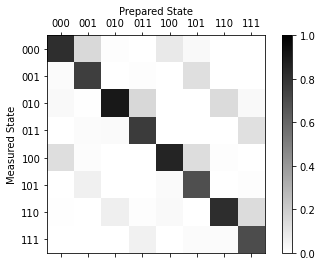

In [9]:
plot_calibration(meas_fitter)

Note that the calibration matrix is in general not invertible, thus requiring a generalized inverse method to solve.  Additionally, the noise is not deterministic, and has fluctuations, so this will in general not give you the ideal noise-free state, but it should bring you closer to it.

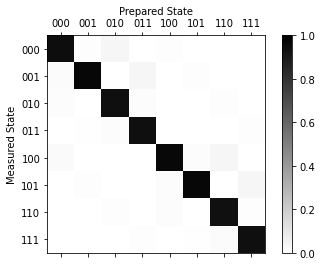

In [10]:
cal_job = backend.retrieve_job('631672ab76f8e34d9f95d63c')
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
plot_calibration(meas_fitter)

In [11]:
from qiskit import QuantumCircuit, transpile

# GHZ state
n = 3
qc = QuantumCircuit(n, n)
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.measure(range(n), range(n))
t_qc = transpile(qc, backend, initial_layout=[5,8,9], optimization_level=3)

In [ ]:
job = backend.run(t_qc)

print(job.job_id())

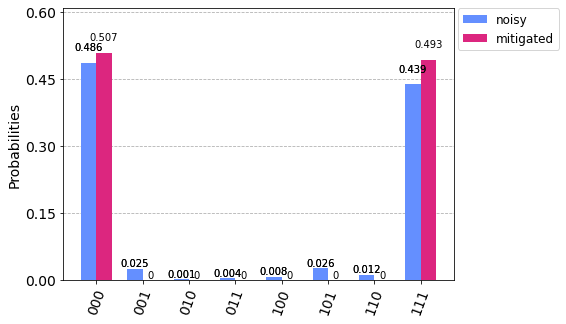

In [12]:
from qiskit.tools.visualization import plot_histogram

# GHZ job I ran before
old_job = backend.retrieve_job('6316807243edaa475aed16e8')
results = old_job.result()
noisy_counts = results.get_counts()
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

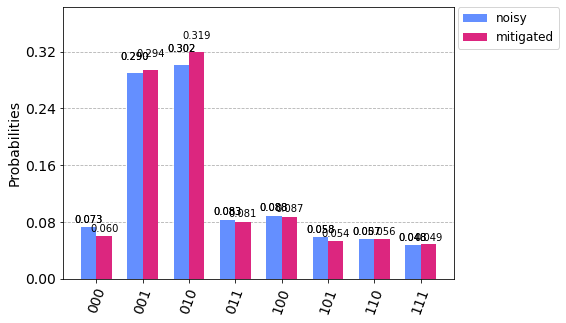

In [13]:
# Grover job I ran before
backend = provider.get_backend('ibm_hanoi')
old_job = backend.retrieve_job('629c83c022557e3921649245')
results = old_job.result()
noisy_counts = results.get_counts(0)
cal_job = backend.retrieve_job('629c818101885c7622f35a8e') # cal job I ran before
cal_results = cal_job.result()
meas_filter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

### Device backend noise model simulations

We have already used the basic ``AerSimulator`` backend to simulate our noise-free results. We will now show how to use the Qiskit Aer noise model, which is generated using the calibration information reported in the ``BackendProperties`` of a device and takes into account

* The gate_error probability of each basis gate on each qubit.
* The gate_length of each basis gate on each qubit.
* The T1, T2 relaxation time constants of each qubit.
* The readout error probability of each qubit.

Let us use the real noise data of ```ibm_nairobi```:

In [14]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeNairobi
fake_backend = FakeNairobi()

# Create simulator from backend 
sim_nairobi = AerSimulator.from_backend(fake_backend)

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

In [21]:
# Transpile the circuit for the noisy basis gates and get results
t_qc = transpile(qc, sim_nairobi)
result_noise = sim_nairobi.run(t_qc, layout = [0,1,2]).result()
counts_sim_noise = result_noise.get_counts(0)

# Compare to ideal simulator
sim_ideal = AerSimulator()
result = sim_ideal.run(transpile(qc, sim_ideal)).result()
counts = result.get_counts(0)

# Compare to actual noisy results
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='summer-school-qi')
backend = provider.get_backend('ibm_nairobi')
old_job = backend.retrieve_job('63174d7043edaa9cf6ed1b06') #[0,1,2]
noisy_counts = old_job.result().get_counts(0)

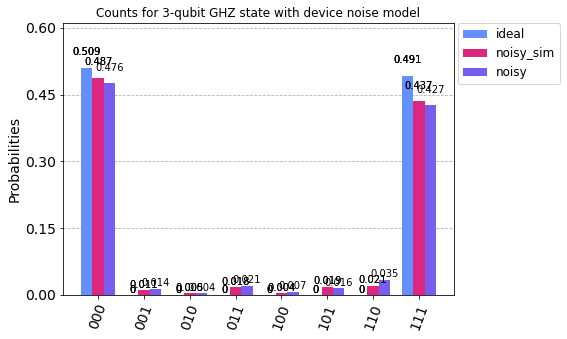

In [22]:
plot_histogram([counts, counts_sim_noise, noisy_counts], legend=['ideal', 'noisy_sim', 'noisy'], title="Counts for 3-qubit GHZ state with device noise model")